# Comparison between real dataset and simulation dataset by edit distance

References
- Metrics [1] S. Kristiansen, T. P. Plagemann and V. Goebel, "An activity rule based approach to simulate adl sequences." IEEE Access, 6(2018), 12551–12572.
- CASAS Aruba dataset (http://casas.wsu.edu/datasets/) [2] D. Cook et al., "CASAS: A Smart Home in a Box." IEEE Computer, 46-7(2013), 62-69.
- Kasteren dataset [3] T. Van Kasteren et al., "Accurate activity recognition in a home setting." Proc. of the 10th international conference on Ubiquitous computing (UbiComp 2008), 1–9.

# Import libraries

In [1]:
import datetime
import itertools
import os
import pprint
import random
import time
from copy import deepcopy
from pathlib import Path
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# self-made
import activity_model
import analysis
import anomaly
import comparison
import floor_plan

import new_functions
import sensor_model

working_path = Path().resolve()
layout_data_path = working_path / 'layout_data'
output_path = working_path / 'output'

## Aruba dataset

In [3]:
Aruba_path = Path('./aruba/data')
Aruba = comparison.load_CASAS_Aruba(Aruba_path)  # some modifications were applied to original data (check comparison.load_CASAS_Aruba)
Aruba_days = comparison.convert_data_into_days(Aruba)  # List of divided activity sequences for each day.

activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])
print(activity_names)
day = 0
print("{} day activity sequence of Aruba dataset".format(day))
for x in Aruba_days[day]:
    print("{}  ({} - {})".format(x[0], x[1].start, x[1].end))

['Sleeping', 'Meal_Preparation', 'Other', 'Relax', 'Housekeeping', 'Take_Breakfast', 'Wash_Dishes', 'Take_Lunch', 'Work', 'Take_Dinner', 'Go_out', 'Nap']
0 day activity sequence of Aruba dataset
Sleeping  (0:00:00 - 8:11:09.966157)
Meal_Preparation  (8:11:09.966157 - 8:35:45.822482)
Other  (8:35:45.822482 - 9:29:23.223133)
Relax  (9:29:23.223133 - 9:34:16.851472)
Housekeeping  (9:34:16.851472 - 9:48:52.342223)
Meal_Preparation  (9:48:52.342223 - 9:56:41.831135)
Take_Breakfast  (9:56:41.831135 - 10:03:21.966597)
Wash_Dishes  (10:03:21.966597 - 10:04:25.772378)
Other  (10:04:25.772378 - 11:29:08.108298)
Housekeeping  (11:29:08.108298 - 11:47:52.575602)
Other  (11:47:52.575602 - 14:46:25.648668)
Relax  (14:46:25.648668 - 15:23:00.012287)
Meal_Preparation  (15:23:00.012287 - 15:25:35.233346)
Take_Lunch  (15:25:35.233346 - 15:28:42.550415)
Other  (15:28:42.550415 - 15:47:48.178484)
Work  (15:47:48.178484 - 16:15:57.476492)
Relax  (16:15:57.476492 - 16:21:59.792013)
Meal_Preparation  (16:21:

### Check frequencies of activities on time of day of Aruba dataset

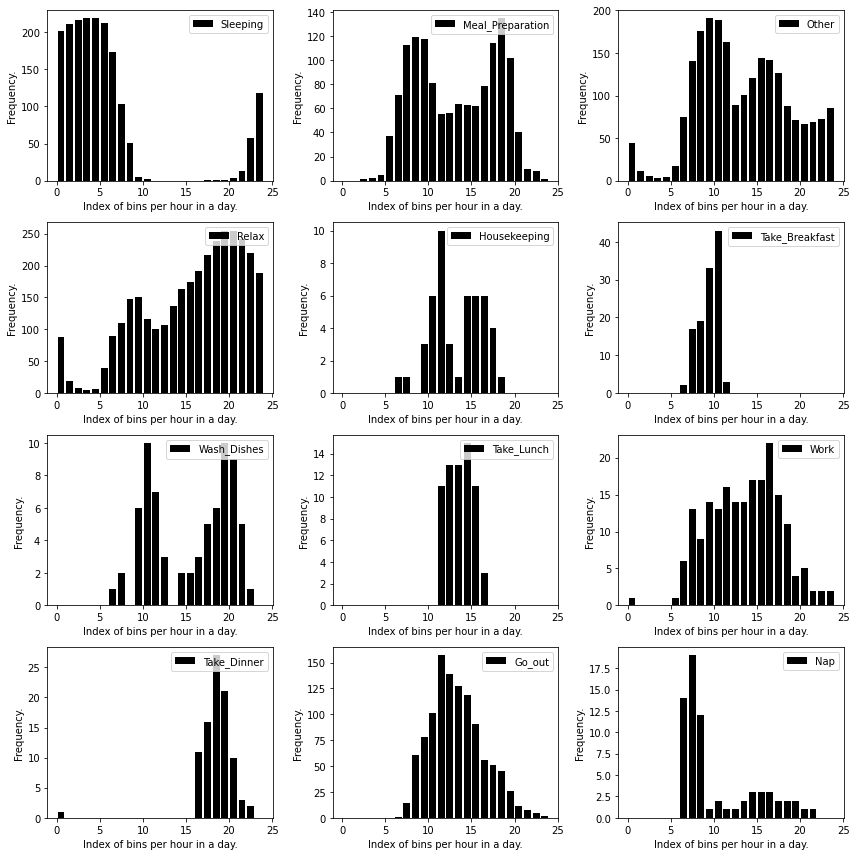

In [8]:
# In the following, it creates a histogram for each action.
# The horizontal axis represents a time interval in which a day is divided into equal time intervals.
# The vertical axis shows the number of times the activity was performed in the time interval in the data.
# count multiple time if multiple same activities are done in the time interval
# e.g., ..., ('TV', 13[h]04[m], 13[h]13[m]), ('Work', 13[h]13[m], 13[h]24[m]), 
#            ('TV', 13[h]24[m], 13[h]45[m]), ('Eating', 13[h]45[m], 14[h]55[m]),
#            ('TV', 13[h]55[m], 14[h]25[m]), ...
# time interval (13:00 - 14:00) counts TV 3 times

# Load Aruba dataset
Aruba_path = Path('./aruba/data')
Aruba = comparison.load_CASAS_Aruba(Aruba_path)  # some modifications were applied to original data (check comparison.load_CASAS_Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

temp_dict = {a: None for a in activity_names}
interval_len = timedelta(hours = 1)  # must be less than 24 [h]
step_len = interval_len / timedelta(hours = 24)
t_list = list(new_functions.date_generator(timedelta(hours = 0), timedelta(hours = 24), step = interval_len))
plot_x = [ 24 * i * step_len for i in range(len(t_list))]
plot_x = [ x + 24 * step_len / 2 for x in plot_x]

for activity_name in activity_names:
    plot_y = [0 for i in t_list]
    for (i, t) in enumerate(t_list):
        interval = new_functions.TimeInterval(t, t + interval_len)
        for day in Aruba_days:
            for a in day:
                if a[0] == activity_name and a[1].overlap(interval) == True:
                    plot_y[i] += 1
    temp_dict[activity_name] = plot_y

fig = plt.figure(figsize=(12,12))
axs = [fig.add_subplot(4, 3, i) for i in range(1,13)]
for i, a in enumerate(activity_names):
    axs[i].set_xlabel('Index of bins per hour in a day.')
    axs[i].set_ylabel('Frequency.')
    axs[i].bar(plot_x, temp_dict[a], label=a, color = 'black')
    axs[i].legend(loc = 'upper right')
fig.tight_layout()
plt.show()
plt.close()

### Check daily frequencies of activities histogram per day of Aruba dataset

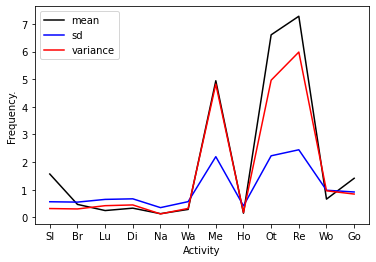

In [14]:
# Load Aruba dataset
Aruba_path = Path('./aruba/data')
Aruba = comparison.load_CASAS_Aruba(Aruba_path)  # some modifications were applied to original data (check comparison.load_CASAS_Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])
        
freq_mean, freq_sd = comparison.estimate_daily_frequency(Aruba, activity_names)
plot_mean = [freq_mean[a] for a in activity_names]
plot_sd = [freq_sd[a] for a in activity_names]
plot_var = [x**2 for x in plot_sd]
plot_x = []
for n in activity_names:  # Abbreaviation of activities to plot
    if n == 'Take_Breakfast':
        plot_x.append('Br')
    elif n == 'Take_Lunch':
        plot_x.append('Lu')
    elif n == 'Take_Dinner':
        plot_x.append('Di')
    else:
        plot_x.append(n[:2])

order = [0, 5, 7, 9, 11, 6, 1, 4, 2, 3, 8, 10]
plt.plot([plot_x[i] for i in order], [plot_mean[i] for i in order], c = 'black', label = 'mean')
plt.plot([plot_x[i] for i in order], [plot_sd[i] for i in order], c = 'blue', label = 'sd')
plt.plot([plot_x[i] for i in order], [plot_var[i] for i in order], c = 'r', label = 'variance')
plt.xlabel('Activity')
plt.ylabel('Frequency.')
plt.legend()
plt.show()
plt.close()

### Statistics of activities in Aruba dataset

Mean start time [hour]: {'Sleeping': 23.792797357000797, 'Take_Breakfast': 9.280758422589825, 'Take_Lunch': 13.444986567168272, 'Take_Dinner': 18.564566220217355}
SD of start time [hour]: {'Sleeping': 1.3825254504899922, 'Take_Breakfast': 1.1465514153031076, 'Take_Lunch': 1.4252454747165457, 'Take_Dinner': 1.462992412473863}
Mean duration time [hour]: {'Sleeping': 6.93457506270895, 'Meal_Preparation': 0.23188109775888477, 'Other': 0.5547298321651979, 'Relax': 1.1372480772231384, 'Housekeeping': 0.4111565623569024, 'Take_Breakfast': 0.1549435418257821, 'Wash_Dishes': 0.14677699736331573, 'Take_Lunch': 0.24759013636831273, 'Work': 0.38633866104938275, 'Take_Dinner': 0.2566882673287672, 'Go_out': 2.4235968311950713, 'Nap': 1.611899301599617}
SD of start time [hour]: {'Sleeping': 1.780218623323245, 'Meal_Preparation': 0.22684304752596204, 'Other': 0.7120286858572163, 'Relax': 1.220544446288422, 'Housekeeping': 0.3761353963129972, 'Take_Breakfast': 0.13864943773542748, 'Wash_Dishes': 0.1427

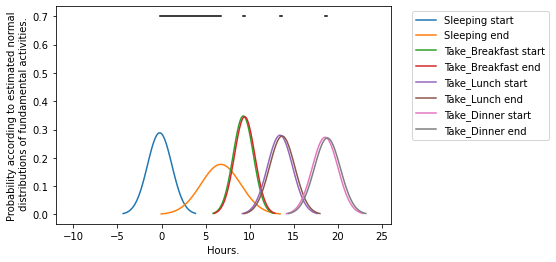

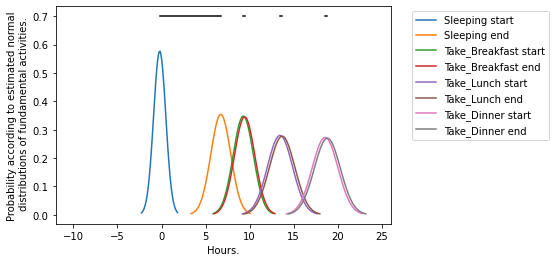

In [5]:
Aruba_path = Path('./aruba/data')
Aruba = comparison.load_CASAS_Aruba(Aruba_path)  # some modification was applied (check comparison.load_CASAS_Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

# learn the fundamental parameters
fundamental_act_names = ['Sleeping', 'Take_Breakfast', 'Take_Lunch', 'Take_Dinner']
start_hour_mean, start_hour_sd = comparison.estimate_start_time(Aruba, fundamental_act_names)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(Aruba, activity_names)
freq_mean, freq_sd = comparison.estimate_daily_frequency(Aruba, activity_names)
    
print("Mean start time [hour]: {}".format(start_hour_mean))
print("SD of start time [hour]: {}".format(start_hour_sd))
print("Mean duration time [hour]: {}".format(duration_hour_mean))
print("SD of start time [hour]: {}".format(duration_hour_sd))
print("Mean daily frequency [times/day]: {}".format(freq_mean))
print("SD of daily frequency [times/day]: {}".format(freq_sd))

# It estimates normal distributions of start time and end_time of each fundamental activity.
for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    if a == 'Sleeping' and mu_s > 12:
        mu_s -= 24
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    X_s = np.arange(mu_s - 3*sigma_s, mu_s + 3*sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3*sigma_e, mu_e + 3*sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label = a + ' start')  # start time
    plt.plot(X_e, Y_e, label = a + ' end')  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c = 'k')
plt.xlim(-12, 26)
plt.xlabel('Hours.')
plt.ylabel('Probability according to estimated normal\n distributions of fundamental activities.')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()


### Modification of sleeping parameters to avoid overlap between 'Sleeping' and 'Take_Breakast'
start_hour_sd['Sleeping'] = start_hour_sd['Sleeping'] / 2
duration_hour_sd['Sleeping'] = duration_hour_sd['Sleeping'] / 2

# It estimates normal distributions of start time and end_time of each fundamental activity.
for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    if a == 'Sleeping' and mu_s > 12:
        mu_s -= 24
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    X_s = np.arange(mu_s - 3*sigma_s, mu_s + 3*sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3*sigma_e, mu_e + 3*sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label = a + ' start')  # start time
    plt.plot(X_e, Y_e, label = a + ' end')  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c = 'k')
plt.xlim(-12, 26)
plt.xlabel('Hours.')
plt.ylabel('Probability according to estimated normal\n distributions of fundamental activities.')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

## Calculate edit distance between converted activity sequences.

Daily activity sequences are converted into string divided by a unit time duration. All pairs of converted sequence was calculated.  
Suppose data1 includes M days and data2 includes N days.  
Same days distance (rho(data)) means a mean distance of all 2-combinations of {1, 2, ..., N}.  
Different days distance (rho(data1, data2)) means a mean distance of elements of Cartesian product {1, 2, ..., M} * {1, 2, ..., N}.  
delta_intra(data) = | rho(data) - rho(Aruba_test) |.  
delta_inter(data) = | rho(data, Aruba_test) - rho(Aruba_test) |.  
The operation | a | means the absolute value of a.  

In [7]:
Aruba_path = Path('./aruba/data')
Aruba = comparison.load_CASAS_Aruba(Aruba_path)  # some modification was applied (check comparison.load_CASAS_Aruba)
Aruba_days = comparison.convert_data_into_days(Aruba)  # List of divided activity sequences for each day.
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])
        
test_data_1 = Aruba_days[:20]
test_data_2 = Aruba_days[20:40]
l = comparison.same_days_distance(test_data_1, timedelta(minutes = 1))
print("Same days distance: {}".format(l))
n = int(2 * len(Aruba_days) / 3)
l_d = comparison.different_days_distance(test_data_1, test_data_2, timedelta(minutes = 1))
print("Different days distance: {}".format(l))

converting days into strings, 100% completed!
calculate distances, 100% completed!
Same days distance: (637.2421052631579, 125.19124030138629)
converting days of Xday into strings, 100% completed!
converting days of Yday into strings, 100% completed!
calculate distances, 100% completed!
Different days distance: (637.2421052631579, 125.19124030138629)


## Generate some datasets for comparison

In [2]:
# modify_sleep_param determines
# whether to shrink (1) the standard deviation of start time of 'Sleeping' and,
#                   (2) the standard deviation of duration time of 'Sleeping'
# to avoid overlap between 'Sleeping' and 'Take_Breakast'.
modify_sleep_param = True

path = Path(layout_data_path / 'test_layout')
# This 'path' does not affect simulated data, but needs to use the function generate_activity_sequence.

# Aruba dataset
Aruba_path = Path('./aruba/data')
Aruba = comparison.load_CASAS_Aruba(Aruba_path)
Aruba_days = comparison.convert_data_into_days(Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

n_t = int(2 * len(Aruba_days) / 3)
Aruba_train = Aruba_days[:n_t]  # Aruba_train is used for parameter estimating.
Aruba_test = Aruba_days[n_t:]
Aruba_n_t = []
for a in Aruba:
    if a[1].end.days < n_t:
        Aruba_n_t.append(a)
    else:
        last_act = (a[0], new_functions.TimeInterval(a[1].start, timedelta(days = n_t)))
        Aruba_n_t.append(last_act)
        break

start_day, end_day = 0, len(Aruba_days) - n_t - 1   
Aruba_act_model = comparison.Aruba_activity_model(n_day = n_t, modify_sleep_param = modify_sleep_param)
Aruba_act_model_sleep_only = comparison.Aruba_activity_model_sleep_only(n_day = n_t)   
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(Aruba_n_t, activity_names)
mean_list = [timedelta(hours = duration_hour_mean[a]) / timedelta(minutes = 1) for a in activity_names]
sd_list = [timedelta(hours = duration_hour_sd[a]) / timedelta(minutes = 1) for a in activity_names]

# Simulation of each dataset is repeated 'N' times.
N = 10
N_days_Aruba_train = []
N_days_Aruba_test = []
N_days_simulation = []
N_days_RD = []  # random duration and random order (RD)
N_days_RS = []  # random duration except for sleep (RS)

for i in range(N):
    # All elements in N_days_Aruba_train (N_days_Aruba_test) are same. This is redundancy, but has uniformity compared to other N_days data.
    N_days_Aruba_train.append(Aruba_train)
    N_days_Aruba_test.append(Aruba_test)
    
    simulation = new_functions.generate_activity_sequence(start_day, end_day, path, original_act_model = Aruba_act_model)
    # change the format of the activity sequence.
    for (i, a) in enumerate(simulation):
        simulation[i] = (a.activity.name, new_functions.TimeInterval(a.start, a.end))
    N_days_simulation.append(comparison.convert_data_into_days(simulation))

    random_data = comparison.generate_random_activity_sequence(start_day, end_day, activity_names, mean_list, sd_list)
    N_days_RD.append(comparison.convert_data_into_days(random_data))

    random_with_fixed_sleep = new_functions.generate_activity_sequence(start_day, end_day, path, original_act_model = Aruba_act_model_sleep_only)
    for (i, a) in enumerate(random_with_fixed_sleep):
        random_with_fixed_sleep[i] = (a.activity.name, new_functions.TimeInterval(a.start, a.end))
    N_days_RS.append(comparison.convert_data_into_days(random_with_fixed_sleep))

### Compare some datasets by edit distance

#### rho(Aruba_train), rho(Aruba_test), rho(Aruba_train, Aruba_test)

In [3]:
time_duration = timedelta(seconds = 30)  # Unit time interval that is converted into one character.
rho_Aruba_train = comparison.same_days_distance(Aruba_train, time_duration)
print("rho(Aruba_train): {}.".format(rho_Aruba_train))
rho_Aruba_test = comparison.same_days_distance(Aruba_test, time_duration)
print("rho(Aruba_test): {}.".format(rho_Aruba_test))
rho_Aruba_train_Aruba_test = comparison.different_days_distance(Aruba_train, Aruba_test, time_duration)
print("rho(Aruba_train, Aruba_test): {}.".format(rho_Aruba_train_Aruba_test))

converting days into strings, 100% completed!
calculate distances, 100% completed!
rho(Aruba_train): (1264.0771846953235, 276.79500180135307).
converting days into strings, 100% completed!
calculate distances, 100% completed!
rho(Aruba_test): (1281.8544983339505, 267.66364740908256).
converting days of Xday into strings, 100% completed!
converting days of Yday into strings, 100% completed!
calculate distances, 100% completed!
rho(Aruba_train, Aruba_test): (1329.98454276194, 273.05039189521085).


#### rho(simulation), rho(RD), rho(RS)

In [4]:
time_duration = timedelta(seconds = 30)

mean_list_S, _ = comparison.mean_same_days_distance(N_days_simulation, time_duration, print_progress = False)
print("rho(simulation): {} (± {}).".format(np.mean(mean_list_S), np.sqrt(np.var(mean_list_S))))

mean_list_RD, _ = comparison.mean_same_days_distance(N_days_RD, time_duration, print_progress = False)
print("rho(RD): {} (± {}).".format(np.mean(mean_list_RD), np.sqrt(np.var(mean_list_RD))))

mean_list_RS, _ = comparison.mean_same_days_distance(N_days_RS, time_duration, print_progress = False)
print("rho(RS): {} (± {}).".format(np.mean(mean_list_RS), np.sqrt(np.var(mean_list_RS))))

rho(simulation): 1309.9208811551277 (± 19.63426049466278).
rho(RD): 1961.1961495742319 (± 58.69390012737198).
rho(RS): 1801.8695298037765 (± 24.454647409949025).


#### delta_intra(simulation), delta_intra(RD), delta_intra(RS), using above cells.

In [6]:
delta_intra_S = np.array(mean_list_S) - rho_Aruba_test[0]
print("delta_intra(simulation): {} (± {}).".format(np.mean(delta_intra_S), np.sqrt(np.var(delta_intra_S))))

delta_intra_RD = np.array(mean_list_RD) - rho_Aruba_test[0]
print("delta_intra(RD): {} (± {}).".format(np.mean(delta_intra_RD), np.sqrt(np.var(delta_intra_RD))))

delta_intra_RS = np.array(mean_list_RS) - rho_Aruba_test[0]
print("delta_intra(RS): {} (± {}).".format(np.mean(delta_intra_RS), np.sqrt(np.var(delta_intra_RS))))

delta_intra(simulation): 28.066382821177264 (± 19.63426049466278).
delta_intra(RD): 679.3416512402813 (± 58.69390012737198).
delta_intra(RS): 520.015031469826 (± 24.454647409949025).


#### rho(simulation, Aruba_test), rho(RD, Aruba_test), rho(RS, Aruba_test)

In [7]:
time_duration = timedelta(seconds = 30)
mean_list_S_AT, _ = comparison.mean_different_days_distance(N_days_simulation, N_days_Aruba_test, time_duration, print_progress = False)
print("rho(simulation, Aruba_test): {} (± {}).".format(np.mean(mean_list_S_AT), np.sqrt(np.var(mean_list_S_AT))))

mean_list_RD_AT, _ = comparison.mean_different_days_distance(N_days_RD, N_days_Aruba_test, time_duration, print_progress = False)
print("rho(RD, Aruba_test): {} (± {}).".format(np.mean(mean_list_RD_AT), np.sqrt(np.var(mean_list_RD_AT))))

mean_list_RS_AT, _ = comparison.mean_different_days_distance(N_days_RS, N_days_Aruba_test, time_duration, print_progress = False)
print("rho(RS, Aruba_test): {} (± {}).".format(np.mean(mean_list_RS_AT), np.sqrt(np.var(mean_list_RS_AT))))

rho(simulation, Aruba_test): 1484.9946859021181 (± 10.457196473241533).
rho(RD, Aruba_test): 2243.966599707816 (± 36.90077401408044).
rho(RS, Aruba_test): 1878.3143352812272 (± 19.779726501555682).


#### delta_inter(simulation), delta_inter(RD), delta_inter(RS), using above cells.

In [9]:
delta_inter_S = np.array(mean_list_S_AT) - rho_Aruba_test[0]
print("delta_inter(simulation): {} (± {}).".format(np.mean(delta_inter_S), np.sqrt(np.var(delta_inter_S))))

delta_inter_RD = np.array(mean_list_RD_AT) - rho_Aruba_test[0]
print("delta_inter(RD): {} (± {}).".format(np.mean(delta_inter_RD), np.sqrt(np.var(delta_inter_RD))))

delta_inter_RS = np.array(mean_list_RS_AT) - rho_Aruba_test[0]
print("delta_inter(RS): {} (± {}).".format(np.mean(delta_inter_RS), np.sqrt(np.var(delta_inter_RS))))

delta_inter(simulation): 203.1401875681679 (± 10.457196473241533).
delta_inter(RD): 962.1121013738655 (± 36.90077401408044).
delta_inter(RS): 596.4598369472767 (± 19.779726501555682).


## kasterenActData

[1] T. Van Kasteren et al., "Accurate activity recognition in a home setting." Proc. of the 10th international conference on Ubiquitous computing (UbiComp 2008), Sep. 2008, 1–9.

In [7]:
path = Path('./kasterenDataset/kasterenActData.txt')
kasteren = comparison.load_kasterenActData(path, first_date = datetime.datetime(year = 2008, month = 2, day = 26),
                                           last_date = datetime.datetime(year = 2008, month = 3, day = 20), remove_exception = True)
kasteren_days = comparison.convert_data_into_days(kasteren)

activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]
print(activity_names)

# Check the number of overlap between two activities
overlap_num = 0
l = len(kasteren)
for (a, b) in itertools.combinations(kasteren, 2):
    overlap_num += a[1].overlap(b[1], exclude_only_1_point = True)
print("overlap combination {} / {}".format(overlap_num, l*(l-1)/2))

['go to bed', 'prepare Breakfast', 'take shower', 'prepare Dinner', 'use toilet', 'leave house', 'get drink', 'Other']
overlap combination 23 / 81003.0


### Check frequencies of activities on time of day of Kasteren dataset

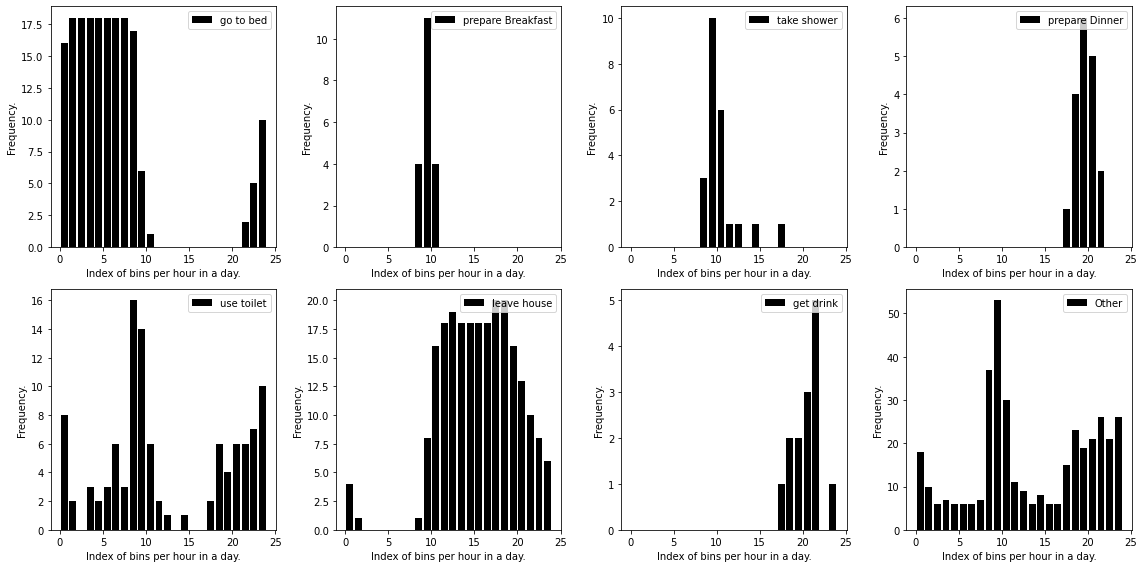

In [9]:
# load kasteren dataset
path = Path('./kasterenDataset/kasterenActData.txt')
kasteren = comparison.load_kasterenActData(path, first_date = datetime.datetime(year = 2008, month = 2, day = 26),
                                           last_date = datetime.datetime(year = 2008, month = 3, day = 20), remove_exception = True)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]


# plot data
temp_dict = {a: None for a in activity_names}
interval_len = timedelta(hours = 1)  # must be less than 24[h]
step_len = interval_len / timedelta(hours = 24)
t_list = list(new_functions.date_generator(timedelta(hours = 0), timedelta(hours = 24), step = interval_len))
plot_x = [ 24 * i * step_len for i in range(len(t_list))]
plot_x = [ x + 24 * step_len / 2 for x in plot_x]

for activity_name in activity_names:
    plot_y = [0 for i in t_list]
    for (i, t) in enumerate(t_list):
        interval = new_functions.TimeInterval(t, t + interval_len)
        for day in kasteren_days:
            for a in day:
                if a[0] == activity_name and a[1].overlap(interval) == True:
                    plot_y[i] += 1
    temp_dict[activity_name] = plot_y

fig = plt.figure(figsize=(16,8))
axs = [fig.add_subplot(2, 4, i) for i in range(1,9)]
for i, a in enumerate(activity_names):
    axs[i].set_xlabel('Index of bins per hour in a day.')
    axs[i].set_ylabel('Frequency.')
    axs[i].bar(plot_x, temp_dict[a], label=a, color = 'k')
    axs[i].legend(loc = 'upper right')
fig.tight_layout()
plt.show()
plt.close()

### Check daily frequencies of activities histogram per day of Kasteren dataset

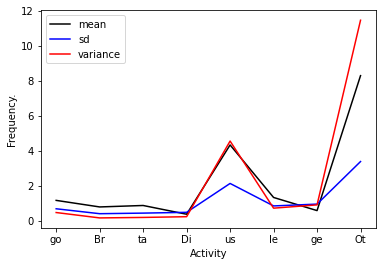

In [10]:
# load kasteren dataset
path = Path('./kasterenDataset/kasterenActData.txt')
kasteren = comparison.load_kasterenActData(path, first_date = datetime.datetime(year = 2008, month = 2, day = 26),
                                           last_date = datetime.datetime(year = 2008, month = 3, day = 20), remove_exception = True)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]

# plot data
freq_mean, freq_sd = comparison.estimate_daily_frequency(kasteren, activity_names)
plot_mean = [freq_mean[a] for a in activity_names]
plot_sd = [freq_sd[a] for a in activity_names]
plot_var = [x**2 for x in plot_sd]
plot_x = []
for n in activity_names:  # Abbreviations of activities.
    if n == 'prepare Breakfast':
        plot_x.append('Br')
    elif n == 'prepare Dinner':
        plot_x.append('Di')
    else:
        plot_x.append(n[:2])

plt.plot(plot_x, plot_mean, c = 'black', label = 'mean')
plt.plot(plot_x, plot_sd, c = 'blue', label = 'sd')
plt.plot(plot_x, plot_var, c = 'r', label = 'variance')
plt.xlabel('Activity')
plt.ylabel('Frequency.')
plt.legend()
plt.show()
plt.close()

### Statistics of activities in Kasteren dataset

Mean start time [hour]: {'go to bed': 23.6023003966612, 'prepare Breakfast': 9.379046430868078, 'take shower': 10.316988426441783, 'prepare Dinner': 19.329628403976432}
SD of start time [hour]: {'go to bed': 1.227236016195215, 'prepare Breakfast': 0.6405681398371801, 'take shower': 2.051722853149245, 'prepare Dinner': 0.8577394594875589}
Mean duration time [hour]: {'go to bed': 9.267875816993463, 'use toilet': 0.030072115384615388, 'Other': 1.0224838330393888, 'prepare Breakfast': 0.05570175438596491, 'take shower': 0.1608201058201058, 'leave house': 7.276706349206348, 'get drink': 0.015912698412698413, 'prepare Dinner': 0.5551851851851852}
SD of start time [hour]: {'go to bed': 1.297650941532453, 'use toilet': 0.028945103589915533, 'Other': 5.029436041148936, 'prepare Breakfast': 0.042581226932893367, 'take shower': 0.043955936011301155, 'leave house': 3.5500820862611744, 'get drink': 0.02200224169160457, 'prepare Dinner': 0.32561930547614254}
Mean daily frequency [times/day]: {'go to

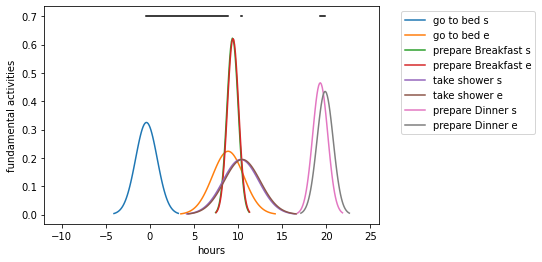

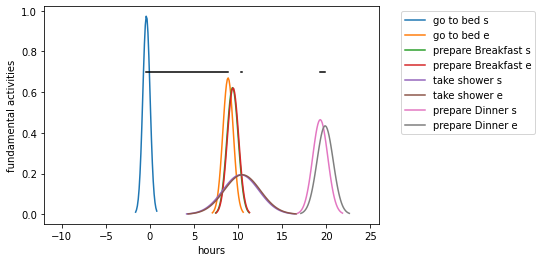

In [19]:
# load kasteren dataset
path = Path('./kasterenDataset/kasterenActData.txt')
kasteren = comparison.load_kasterenActData(path, first_date = datetime.datetime(year = 2008, month = 2, day = 26),
                                           last_date = datetime.datetime(year = 2008, month = 3, day = 20), remove_exception = True)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]

# learn the fundamental parameters
fundamental_act_names = ['go to bed', 'prepare Breakfast', 'take shower', 'prepare Dinner']
start_hour_mean, start_hour_sd = comparison.estimate_start_time(kasteren, fundamental_act_names)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(kasteren)
freq_mean, freq_sd = comparison.estimate_daily_frequency(kasteren)
    
print("Mean start time [hour]: {}".format(start_hour_mean))
print("SD of start time [hour]: {}".format(start_hour_sd))
print("Mean duration time [hour]: {}".format(duration_hour_mean))
print("SD of start time [hour]: {}".format(duration_hour_sd))
print("Mean daily frequency [times/day]: {}".format(freq_mean))
print("SD of daily frequency [times/day]: {}".format(freq_sd))

# It estimates normal distributions of start time and end_time of each fundamental activity.
for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    if a == 'go to bed' and mu_s > 12:
        mu_s -= 24
    X_s = np.arange(mu_s - 3*sigma_s, mu_s + 3*sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3*sigma_e, mu_e + 3*sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label = a + ' s')  # start time
    plt.plot(X_e, Y_e, label = a + ' e')  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c = 'k')
plt.xlim(-12, 26)
plt.xlabel('hours')
plt.ylabel('fundamental activities')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

### Modification of sleeping parameters to avoid overlap.
start_hour_sd['go to bed'] = start_hour_sd['go to bed'] / 3
duration_hour_sd['go to bed'] = duration_hour_sd['go to bed'] / 3

for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    if a == 'go to bed' and mu_s > 12:
        mu_s -= 24
    X_s = np.arange(mu_s - 3*sigma_s, mu_s + 3*sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3*sigma_e, mu_e + 3*sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label = a + ' s')  # start time
    plt.plot(X_e, Y_e, label = a + ' e')  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c = 'k')
plt.xlim(-12, 26)
plt.xlabel('hours')
plt.ylabel('fundamental activities')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

### Generate some datasets for comparison

In [2]:
# modify_sleep_param determines
# whether to shrink (1) the standard deviation of start time of 'go to bed' and,
#                   (2) the standard deviation of duration time of 'go to bed'
# to avoid overlap between 'go to bed' and 'prepare Breakfast'.
modify_sleep_param = True

path = Path(layout_data_path / 'test_layout')
# This 'path' does not affect simulated data, but needs to use the function generate_activity_sequence.

# load kasteren dataset
kasteren_path = Path('./kasterenDataset/kasterenActData.txt')
kasteren = comparison.load_kasterenActData(kasteren_path, first_date = datetime.datetime(year = 2008, month = 2, day = 26),
                                           last_date = datetime.datetime(year = 2008, month = 3, day = 20),
                                           add_other = True, remove_exception = False)
train = comparison.load_kasterenActData(kasteren_path, first_date = datetime.datetime(year = 2008, month = 2, day = 26),
                                        last_date = datetime.datetime(year = 2008, month = 3, day = 20),
                                        add_other = True, remove_exception = True)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]
start_day, end_day = 0, len(kasteren_days) - 1

kasteren_act_model = comparison.kasteren_activity_model(train, modify_sleep_param = modify_sleep_param)
kasteren_act_model_sleep = comparison.kasteren_activity_model_sleep_only(train, modify_sleep_param = modify_sleep_param)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(train, activity_names)
mean_list = [timedelta(hours = duration_hour_mean[a]) / timedelta(minutes = 1) for a in activity_names]
sd_list = [timedelta(hours = duration_hour_sd[a]) / timedelta(minutes = 1) for a in activity_names]


# Simulation of each dataset is repeated 'N' times.
N = 10
N_days_kasteren = []
N_days_simulation = []
N_days_RD = []  # random duration and random order (RD)
N_days_RS = []  # random duration except for sleep (RS)

for i in range(N):
    # All elements in N_days_kasteren are same. This is redundancy, but has uniformity compared to other N_days data.
    N_days_kasteren.append(kasteren_days)
    
    simulation = new_functions.generate_activity_sequence(start_day, end_day, path, original_act_model = kasteren_act_model)
    # change the format of the activity sequence.
    for (i, a) in enumerate(simulation):
        simulation[i] = (a.activity.name, new_functions.TimeInterval(a.start, a.end))
    N_days_simulation.append(comparison.convert_data_into_days(simulation))

    random_data = comparison.generate_random_activity_sequence(start_day, end_day, activity_names, mean_list, sd_list)
    N_days_RD.append(comparison.convert_data_into_days(random_data))

    random_data_sleep = new_functions.generate_activity_sequence(start_day, end_day, path, original_act_model = kasteren_act_model_sleep)
    for (i, a) in enumerate(random_data_sleep):
        random_data_sleep[i] = (a.activity.name, new_functions.TimeInterval(a.start, a.end))
    N_days_RS.append(comparison.convert_data_into_days(random_data_sleep))

### Compare some datasets by edit distance

#### rho(kasteren)

In [3]:
time_duration = timedelta(seconds = 30)  # Unit time interval that is converted into one character.
rho_kasteren = comparison.same_days_distance(kasteren_days, time_duration)
print("rho(kasteren): {}.".format(rho_kasteren))

converting days into strings, 100% completed!
calculate distances, 100% completed!
rho(kasteren): (1027.8188405797102, 500.7003390253546).


#### rho(simulation), rho(RD), rho(RS), delta_intra(simulation), delta_intra(RD), delta_intra(RS).

In [4]:
time_duration = timedelta(seconds = 30)

mean_list_S, _ = comparison.mean_same_days_distance(N_days_simulation, time_duration, print_progress = False)
print("rho(simulation): {} (± {}).".format(np.mean(mean_list_S), np.sqrt(np.var(mean_list_S))))

mean_list_RD, _ = comparison.mean_same_days_distance(N_days_RD, time_duration, print_progress = False)
print("rho(RD): {} (± {}).".format(np.mean(mean_list_RD), np.sqrt(np.var(mean_list_RD))))

mean_list_RS, _ = comparison.mean_same_days_distance(N_days_RS, time_duration, print_progress = False)
print("rho(RS): {} (± {}).".format(np.mean(mean_list_RS), np.sqrt(np.var(mean_list_RS))))

delta_intra_S = np.array(mean_list_S) - rho_kasteren[0]
print("delta_intra(simulation): {} (± {}).".format(np.mean(delta_intra_S), np.sqrt(np.var(delta_intra_S))))

delta_intra_RD = np.array(mean_list_RD) - rho_kasteren[0]
print("delta_intra(RD): {} (± {}).".format(np.mean(delta_intra_RD), np.sqrt(np.var(delta_intra_RD))))

delta_intra_RS = np.array(mean_list_RS) - rho_kasteren[0]
print("delta_intra(RS): {} (± {}).".format(np.mean(delta_intra_RS), np.sqrt(np.var(delta_intra_RS))))

rho(simulation): 923.1177536231884 (± 31.29757111172007).
rho(RD): 1567.9989130434783 (± 45.860264043414524).
rho(RS): 799.9547101449275 (± 76.82590436582414).
delta_intra(simulation): -104.70108695652183 (± 31.297571111720067).
delta_intra(RD): 540.180072463768 (± 45.860264043414524).
delta_intra(RS): -227.86413043478268 (± 76.82590436582414).


#### rho(simulation, kasteren), rho(RD, kasteren), rho(RS, kasteren), delta_inter(simulation), delta_inter(RD), delta_inter(RS).

In [5]:
time_duration = timedelta(seconds = 30)
mean_list_S_k, _ = comparison.mean_different_days_distance(N_days_simulation, N_days_kasteren, time_duration, print_progress = False)
print("rho(simulation, kasteren): {} (± {}).".format(np.mean(mean_list_S_k), np.sqrt(np.var(mean_list_S_k))))

mean_list_RD_k, _ = comparison.mean_different_days_distance(N_days_RD, N_days_kasteren, time_duration, print_progress = False)
print("rho(RD, kasteren): {} (± {}).".format(np.mean(mean_list_RD_k), np.sqrt(np.var(mean_list_RD_k))))

mean_list_RS_k, _ = comparison.mean_different_days_distance(N_days_RS, N_days_kasteren, time_duration, print_progress = False)
print("rho(RS, kasteren): {} (± {}).".format(np.mean(mean_list_RS_k), np.sqrt(np.var(mean_list_RS_k))))

delta_inter_S = np.array(mean_list_S_k) - rho_kasteren[0]
print("delta_inter(simulation): {} (± {}).".format(np.mean(delta_inter_S), np.sqrt(np.var(delta_inter_S))))

delta_inter_RD = np.array(mean_list_RD_k) - rho_kasteren[0]
print("delta_inter(RD): {} (± {}).".format(np.mean(delta_inter_RD), np.sqrt(np.var(delta_inter_RD))))

delta_inter_RS = np.array(mean_list_RS_k) - rho_kasteren[0]
print("delta_inter(RS): {} (± {}).".format(np.mean(delta_inter_RS), np.sqrt(np.var(delta_inter_RS))))

rho(simulation, kasteren): 1262.2739583333332 (± 35.360192837222094).
rho(RD, kasteren): 1676.809375 (± 106.81046562546963).
rho(RS, kasteren): 1004.5125 (± 46.79647206848523).
delta_inter(simulation): 234.4551177536231 (± 35.360192837222094).
delta_inter(RD): 648.9905344202898 (± 106.81046562546963).
delta_inter(RS): -23.30634057971024 (± 46.79647206848523).


# Figures

## MMSE and parameters of wandering

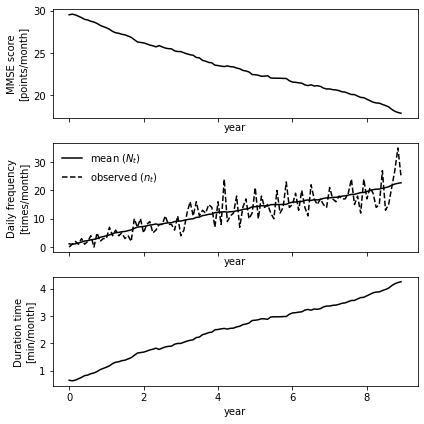

In [10]:
start, end, step = timedelta(days = 0), timedelta(days = 9 * 360), timedelta(days = 30)
MMSE = anomaly.simulate_MMSE(start, end, step, error_e = 0)

# about wandering
def calculate_wandering_num(mmse):
    # decide the number of wandering
    if mmse < 0 or 30 < mmse:
        raise ValueError('mmse must be 0 <= mmse <= 30')
    return - 1.86 * mmse + 56
def calculate_wandering_duration(mmse):
    # decide the duration time of wandering
    if mmse < 0 or 30 < mmse:
        raise ValueError('mmse must be 0 <= mmse <= 30')
    return - 0.31 * mmse + 9.8
wandering_mean_num = anomaly.simulate_values_from_MMSE(MMSE, start, end, step, calculate_wandering_num)
wandering_num = [(x[0], x[1], stats.poisson.rvs(x[2])) for x in wandering_mean_num]
wandering_mean_duration = anomaly.simulate_values_from_MMSE(MMSE, start, end, step, calculate_wandering_duration)

# graph
graph_time_step = timedelta(days = 30 * 12)
fig, ax = plt.subplots(3, 1, sharex='col', facecolor='w', figsize=(6, 6))
ax[0].plot([x[0] / graph_time_step for x in MMSE], [x[2] for x in MMSE], 'k-')
ax[0].set_xlabel('year')
ax[0].set_ylabel('MMSE score\n[points/month]')
ax[1].plot([x[0] / graph_time_step for x in wandering_mean_num], [x[2] for x in wandering_mean_num], 'k-', label = 'mean ($N_t$)')
ax[1].plot([x[0] / graph_time_step for x in wandering_num], [x[2] for x in wandering_num], 'k--', label = 'observed ($n_t$)')
ax[1].legend(loc = 'best', frameon = False)
ax[1].set_xlabel('year')
ax[1].set_ylabel('Daily frequency\n[times/month]')
ax[2].plot([x[0] / graph_time_step for x in wandering_mean_duration], [x[2] for x in wandering_mean_duration], 'k-', label = 'mean($D_t$)')
ax[2].set_xlabel('year')
ax[2].set_ylabel('Duration time\n[min/month]')
plt.tight_layout()
save_file_name = "wandering_simulations"
plt.savefig("{}/{}.png".format(str(output_path), save_file_name), dpi = 500)
plt.show()
plt.close()